# Predict Movie Box Office

To predict the boxoffice for a movie using the pre-processed datasets from the IMDb and WorldBoxOffice data sources.
refer: https://github.com/madsenmj/iot-ml-imdb-demo/tree/master/src

In [1]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import cluster
from sklearn import tree
from sklearn import ensemble
from sklearn import preprocessing

# Compute confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load the dataset, then use the LabelEncoder to create labels for the Director and Genre columns. Finally, encode the year as a label as well.

In [3]:
import re
import string

FIELDS = ['worldGross','originalTitle','startYear','firstRelaseDate', 
          'runtimeMinutes', 'averageRating',
          'genres', 'directors', 'writers', 'principalCast', 
          'genres1', 'genres2', 'genres3', 
          'director1', 'director2', 'director3', 'director4',
          'writer1', 'writer2', 'writer3', 'writer4',
          'principalCast1', 'principalCast2', 'principalCast3', 'principalCast4',
          'principalCast5', 'principalCast6', 'principalCast7', 'principalCast8',
          'summaries', 'synopsis', 
          'productionCo', 'productionCo1', 'productionCo2', 'productionCo3'
          ]

# df = pd.read_csv("./input/movie_title_list_simple.csv")
df = pd.read_csv("./input/movie_title_list_v1.00.csv")

# max_len = 0
# for d in df['genres']:
# for d in df['directors']:
# for d in df['writers']:
# for d in df['principalCast']:
#     l=len(str(d).split(','))
#     if l>4:
#         print(d)
#     max_len = l if l > max_len else max_len
# print(max_len)

temp_df = pd.DataFrame()
temp_df = df.reindex(columns = FIELDS)

for i in range(0, len(df.index)):
    slist=str(df.loc[i, 'genres']).split(',')
    l = len(slist)
    for j in range(0, 3 if l > 3 else l):
        colname = 'genres' + str(j+1)
        temp_df.loc[i, colname] = slist[j]
        
    slist=str(df.loc[i, 'directors']).split(',')
    l = len(slist)
    for j in range(0, 4 if l > 4 else l):
        colname = 'director' + str(j+1)
        temp_df.loc[i, colname] = slist[j]
        
    slist=str(df.loc[i, 'writers']).split(',')
    l = len(slist)
    for j in range(0, 4 if l > 4 else l):
        colname = 'writer' + str(j+1)
        temp_df.loc[i, colname] = slist[j]        
        
    slist=str(df.loc[i, 'principalCast']).split(',')
    l = len(slist)
    for j in range(0, 8 if l > 8 else l):
        colname = 'principalCast' + str(j+1)
        temp_df.loc[i, colname] = slist[j]
        
    slist=str(df.loc[i, 'productionCo']).split(',')
    l = len(slist)
    for j in range(0, 3 if l > 3 else l):
        colname = 'productionCo' + str(j+1)
        temp_df.loc[i, colname] = slist[j]
    
    temp_df.loc[i, 'firstRelaseDate'] = str(temp_df.loc[i, 'firstRelaseDate'])[5:]

    for ch in string.punctuation: 
        temp_df.loc[i, 'originalTitle'] = str(temp_df.loc[i, 'originalTitle']).replace(ch, "") 
        temp_df.loc[i, 'summaries'] = str(temp_df.loc[i, 'summaries']).replace(ch, "")
        temp_df.loc[i, 'synopsis'] = str(temp_df.loc[i, 'synopsis']).replace(ch, "")
        
print(temp_df.head())

   worldGross                             originalTitle  startYear  \
0      2788.0                                    Avatar       2009   
1      2187.4                                   Titanic       1997   
2      2187.4                                   Titanic       1953   
3      2066.0  Star Wars Episode VII  The Force Awakens       2015   
4      1670.4                            Jurassic World       2015   

  firstRelaseDate  runtimeMinutes  averageRating                    genres  \
0           12-10           162.0            7.8  Action,Adventure,Fantasy   
1           11-01           194.0            7.8             Drama,Romance   
2           04-11            98.0            7.2     Drama,History,Romance   
3           12-14           136.0            8.1  Action,Adventure,Fantasy   
4           05-29           124.0            7.0   Action,Adventure,Sci-Fi   

   directors                                            writers  \
0  nm0000116                               

In [5]:
import nltk
from nltk.stem.snowball import SnowballStemmer as stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

CLUSTERSNUM = 100

# Tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer("english").stem(t) for t in filtered_tokens]
    return stems

# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                   min_df=0.1, stop_words='english', analyzer='word',
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

# clusters of the summaries
tfidf_matrix = tfidf_vectorizer.fit_transform(temp_df['summaries'].astype(str)) 
terms_summaries = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)
print(terms_summaries)

km = KMeans(n_clusters=CLUSTERSNUM)
km.fit(tfidf_matrix)
temp_df['summaries_clusters'] = km.labels_.tolist()
print(temp_df['summaries_clusters'])

# clusters of the synoposes 
tfidf_matrix = tfidf_vectorizer.fit_transform(temp_df['synopsis'].astype(str)) 
terms_synopsis = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)
print(terms_synopsis)

km = KMeans(n_clusters=CLUSTERSNUM)
km.fit(tfidf_matrix)
temp_df['synopsis_clusters'] = km.labels_.tolist()
print(temp_df['synopsis_clusters'])

(13489, 97)
['anoth', 'becaus', 'becom', 'befor', 'begin', 'believ', 'best', 'brazil', 'bring', 'carvalho', 'carvalho rio', 'carvalho rio janeiro', 'chang', 'citi', 'come', 'daughter', 'day', 'death', 'decid', 'discov', 'doe', 'dure', 'end', 'fall', 'famili', 'father', 'film', 'follow', 'forc', 'friend', 'girl', 'goe', 'group', 'help', 'hes', 'home', 'howev', 'janeiro', 'janeiro brazil', 'job', 'just', 'kill', 'know', 'lead', 'learn', 'leav', 'life', 'like', 'live', 'look', 'love', 'make', 'man', 'marri', 'meet', 'mother', 'murder', 'new', 'old', 'onli', 'peopl', 'person', 'place', 'plan', 'relationship', 'return', 'rio', 'rio janeiro', 'rio janeiro brazil', 'run', 'save', 'secret', 'set', 'son', 'soon', 'start', 'stori', 'tell', 'thing', 'time', 'togeth', 'town', 'tri', 'turn', 'use', 'want', 'way', 'wife', 'woman', 'work', 'world', 'year', 'young', '—anonym', '—claudio', '—claudio carvalho', '—claudio carvalho rio']
0        43
1        61
2        42
3        48
4        48
5       

(13489, 9404)
['0', '1', '10', '100', '1000', '10000', '1001', '101', '102', '10th', '11', '110th', '1138', '117', '11th', '12', '120', '123', '127', '13', '13th', '1408', '1453', '1492', '15', '16', '1600', '17', '175', '1776', '18', '1838', '19', '1915', '1941', '1944', '1945', '19671975', '1969', '1975', '1999', '1st', '2', '20', '200', '2000', '20000', '2001', '2010', '2012', '2013', '2016', '2046', '2049', '20th', '21', '21st', '22', '222', '23', '237', '24', '25', '25th', '2611', '27', '28', '29', '2929', '29th', '2nd', '3', '30', '300', '3000', '31', '310', '33', '34th', '35', '36', '360', '37th', '39', '3b', '3d', '3dd', '3rd', '4', '40', '4111', '42', '422', '42nd', '43', '44', '45', '46', '47', '48', '49', '4d', '4ever', '5', '50', '500', '5050', '507', '51', '51st', '52', '54', '55', '57', '5th', '6', '60', '61', '65000', '66', '6th', '7', '71', '73', '77', '786', '79', '7beonbangui', '7th', '8', '80', '81', '84', '84c', '88', '8mm', '8th', '9', '90', '9000', '911', '93', '9

ValueError: x and y must have same first dimension, but have shapes (20,) and (99,)

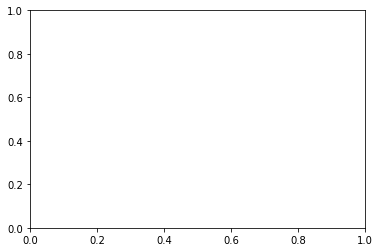

In [22]:
def tokenize_and_stem_t(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[\da-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer("english").stem(t) for t in filtered_tokens]
    return stems

CLUSTERSNUM_T = 100

# clusters of the title 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', analyzer='word',
                                   use_idf=False, tokenizer=tokenize_and_stem_t, ngram_range=(1,1))

tfidf_matrix = tfidf_vectorizer.fit_transform(temp_df['originalTitle'].astype(str)) 
terms_originalTitle = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)
print(terms_originalTitle)

km = KMeans(n_clusters=CLUSTERSNUM_T)
km.fit(tfidf_matrix)
temp_df['originalTitle_clusters'] = km.labels_.tolist()
print(temp_df['originalTitle_clusters'])

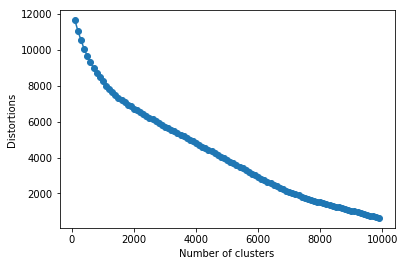

In [23]:
CLUSTERSMAX = 10000
distortions = []
for i in range (100, CLUSTERSMAX, 100):
    km = KMeans(n_clusters = i)
    km.fit(tfidf_matrix)
    distortions.append(km.inertia_)
    
plt.plot(range(100, CLUSTERSMAX, 100), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.show()

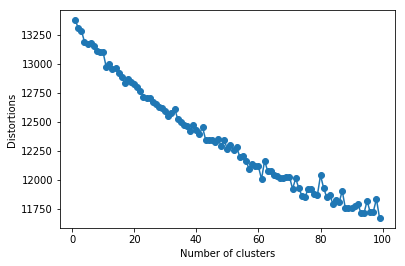

In [20]:
plt.plot(range(1, CLUSTERSMAX), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.show()

In [ ]:
genres = pd.concat([temp_df['genres1'], temp_df['genres2'], temp_df['genres3']])
directors = pd.concat([temp_df['director1'],temp_df['director2'],temp_df['director3'],temp_df['director4']])
writers = pd.concat([temp_df['writer1'],temp_df['writer2'],temp_df['writer3'],temp_df['writer4']])
principalCast = pd.concat([temp_df['principalCast1'],temp_df['principalCast2'],
                           temp_df['principalCast3'],temp_df['principalCast4'],
                           temp_df['principalCast5'],temp_df['principalCast6'],
                           temp_df['principalCast7'],temp_df['principalCast8']])

#Try model fitting on just direc        if re.search('[a-zA-Z]', token):tor, year, and genre and see 8, max_feawhat we get.
dfred = pd.DataFrame()
y=(temp_df["worldGross"].reset_index())['worldGross']

leD = preprocessing.LabelEncoder()
leD.fit(genres.astype(str))
for j in range(0, 1):
    colname = 'genres' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

leD = preprocessing.LabelEncoder()
leD.fit(directors.astype(str))
for j in range(0, 4):
    colname = 'director' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

leD.fit(writers.astype(str))
for j in range(0, 4):
    colname = 'writer' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

leD.fit(principalCast.astype(str))
for j in range(0, 8):
    colname = 'principalCast' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

leY = preprocessing.LabelEncoder()
leY.fit(temp_df['startYear'])
dfred['startYear'] = leY.transform(temp_df['startYear'])

print("y: %s"%(y))
print(dfred)

In [16]:
genres = pd.concat([temp_df['genres1'], temp_df['genres2'], temp_df['genres3']])
directors = pd.concat([temp_df['director1'],temp_df['director2'],temp_df['director3'],temp_df['director4']])
writers = pd.concat([temp_df['writer1'],temp_df['writer2'],temp_df['writer3'],temp_df['writer4']])
principalCast = pd.concat([temp_df['principalCast1'],temp_df['principalCast2'],
                           temp_df['principalCast3'],temp_df['principalCast4'],
                           temp_df['principalCast5'],temp_df['principalCast6'],
                           temp_df['principalCast7'],temp_df['principalCast8']])
productionCo = pd.concat([temp_df['productionCo1'], temp_df['productionCo2'], temp_df['productionCo3']])

#Try model fitting on just director, year, and genre and see what we get.
dfred = pd.DataFrame()

# y=(temp_df["worldGross"].reset_index())['worldGross']
# for i in range(0, len(df.index)):
#     if df.loc[i, 'worldGross'] > 31.7
#         y[i] = 4
#     elif df.loc[i, 'worldGross'] > 5.1:
#         y[i] = 3
#     elif df.loc[i, 'worldGross'] > 0.6:
#         y[i] = 2
#     else:
#         y[i] = 1        

# y = np.log(temp_df['worldGross']) +  2.0 #2.3026
y = np.log(temp_df['worldGross']+1)
for i in range(0, len(df.index)):
    y[i] = int(y[i]) 

leD = preprocessing.LabelEncoder()
leD.fit(genres.astype(str))
for j in range(0, 3):
    colname = 'genres' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

leD = preprocessing.LabelEncoder()
leD.fit(directors.astype(str))
for j in range(0, 4):
    colname = 'director' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

leD.fit(writers.astype(str))
for j in range(0, 4):
    colname = 'writer' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

# leD.fit(principalCast.astype(str))
# for j in range(0, 8):
#     colname = 'principalCast' + str(j+1)
#     dfred[colname] = leD.transform(temp_df[colname].astype(str))

leD = preprocessing.LabelEncoder() 
leD.fit(productionCo.astype(str))
for j in range(0, 3):
    colname = 'productionCo' + str(j+1)
    dfred[colname] = leD.transform(temp_df[colname].astype(str))

leY = preprocessing.LabelEncoder()
leY.fit(temp_df['startYear'])
dfred['startYear'] = leY.transform(temp_df['startYear'])

leY = preprocessing.LabelEncoder()
leY.fit(temp_df['firstRelaseDate'])
dfred['firstRelaseDate'] = leY.transform(temp_df['firstRelaseDate'])

# leR = preprocessing.LabelEncoder()
# leR.fit(temp_df['runtimeMinutes'].astype(str))
# dfred['runtimeMinutes'] = leR.transform(temp_df['runtimeMinutes'].astype(str))

# leY = preprocessing.LabelEncoder()
# leY.fit(temp_df['averageRating'])
# dfred['averageRating'] = leY.transform(temp_df['averageRating'])

# leY = preprocessing.LabelEncoder()
# leY.fit(temp_df['summaries_clusters'])
# dfred['summaries_clusters'] = leY.transform(temp_df['summaries_clusters'])

leC = preprocessing.LabelEncoder()
leC.fit(temp_df['synopsis_clusters'])
dfred['synopsis_clusters'] = leC.transform(temp_df['synopsis_clusters'])

leC = preprocessing.LabelEncoder()
leC.fit(temp_df['originalTitle_clusters'])
dfred['originalTitle_clusters'] = leC.transform(temp_df['originalTitle_clusters'])

print(y)
print(dfred)

0        7.0
1        7.0
2        7.0
3        7.0
4        7.0
5        7.0
6        7.0
7        7.0
8        7.0
9        7.0
10       7.0
11       7.0
12       7.0
13       7.0
14       7.0
15       7.0
16       7.0
17       7.0
18       7.0
19       7.0
20       7.0
21       6.0
22       6.0
23       6.0
24       6.0
25       6.0
26       6.0
27       6.0
28       6.0
29       6.0
        ... 
13459    0.0
13460    0.0
13461    0.0
13462    0.0
13463    0.0
13464    0.0
13465    0.0
13466    0.0
13467    0.0
13468    0.0
13469    0.0
13470    0.0
13471    0.0
13472    0.0
13473    0.0
13474    0.0
13475    0.0
13476    0.0
13477    0.0
13478    0.0
13479    0.0
13480    0.0
13481    0.0
13482    0.0
13483    0.0
13484    0.0
13485    0.0
13486    0.0
13487    0.0
13488    0.0
Name: worldGross, Length: 13489, dtype: float64
       genres1  genres2  genres3  director1  director2  director3  director4  \
0            0        2       10         24          0          0          0   

score = 0.44996293550778355
[  5.04e-02   5.58e-02   4.39e-02   9.75e-02   4.12e-03   3.43e-04
   2.41e-05   8.80e-02   6.06e-02   3.21e-02   1.47e-02   9.81e-02
   7.21e-02   5.02e-02   1.10e-01   8.57e-02   1.16e-01   2.00e-02]
Confusion matrix, without normalization
[[443  20  17  12   9   4   1   0]
 [136  23  25  17  11   1   0   0]
 [106  15  35  30   6   4   0   0]
 [ 64   6  27  40  30   8   0   0]
 [ 40   8  17  27  35  13   1   0]
 [ 16   1   3  16  21  24   4   0]
 [  1   0   1   1  10  10   7   0]
 [  1   0   0   0   1   1   0   0]]


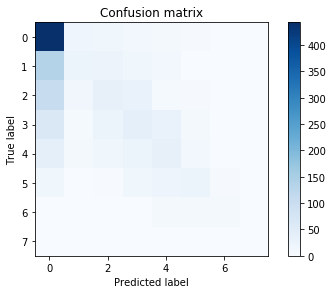

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dfred,y,test_size=0.10, random_state=1) 

# dtc = tree.DecisionTreeClassifier(min_samples_leaf=2)
# dtc = ensemble.RandomForestClassifier(n_estimators=200,min_samples_leaf=5)
# dtc = svm.SVC(kernel='rbf',gamma=10,C=1000,probability=True)
dtc = ensemble.RandomForestClassifier(n_estimators=200,min_samples_leaf=5)
dtc.fit(X_train.astype(str),y_train)
print( "score = {}".format(dtc.score(X_test.astype(str),y_test)))
print (dtc.feature_importances_)
terms_originalTitle = tfidf_vectorizer
pdata =dtc.predict(X_test.astype(str))

# dtc_probs = dtc.predict_proba(X_test)
# score = log_loss(y_test, dtc_probs)
# print( "logloss = {}".format(score))

cm = confusion_matrix(y_test.astype(str), pdata.astype(str))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [ ]:
TEST_FIELDS = ['worldGross','originalTitle','startYear','firstRelaseDate', 
          'runtimeMinutes', 'averageRating',
          'genres', 'directors', 'writers', 'principalCast', 
          'genres1', 'genres2', 'genres3', 
          'summaries', 'synopsis', 
          'productionCo',
          'summaries_clusters','synopsis_clusters', 'originalTitle_clusters'
          ]

test_df = temp_pd.DataFrame()
test_df = temp_df.reindex(columns = TEST_FIELDS)
test_df.get_dummies
print(test_df)